In [1]:
# Install necessary packages (run only if not installed)
!pip install tensorflow scikit-learn matplotlib pandas


  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached scipy-1.16.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
Using cached mat


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import random


In [25]:
# Load CSV
df = pd.read_csv('UPVillageSchedule.csv')

# Keep only numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df_numeric = df_numeric.fillna(df_numeric.mean())

# Scale
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_numeric.values)


In [26]:
LOOKBACK = 10

def create_sequences(data, lookback=LOOKBACK):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, 0])  # first column as target
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled)

# Train-test split 80-20
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [28]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_split=0.2, verbose=1)

y_pred_lstm = model.predict(X_test).reshape(-1)


Epoch 1/4
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 4.0519e-04 - val_loss: 7.4123e-04
Epoch 2/4
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 3.9886e-04 - val_loss: 7.4178e-04
Epoch 3/4
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 3.9728e-04 - val_loss: 7.4201e-04
Epoch 4/4
2128/2128 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 3.9682e-04 - val_loss: 7.5604e-04
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [29]:
# Flatten for RF
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Optional downsample for speed
max_samples = 20000
if X_train_flat.shape[0] > max_samples:
    idx = np.random.choice(X_train_flat.shape[0], max_samples, replace=False)
    X_train_flat_sampled = X_train_flat[idx]
    y_train_sampled = y_train[idx]
else:
    X_train_flat_sampled = X_train_flat
    y_train_sampled = y_train

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_flat_sampled, y_train_sampled)
y_pred_rf = rf.predict(X_test_flat)


In [30]:
# Optional downsample for speed
if X_train_flat.shape[0] > max_samples:
    idx = np.random.choice(X_train_flat.shape[0], max_samples, replace=False)
    X_train_flat_sampled = X_train_flat[idx]
    y_train_sampled = y_train[idx]
else:
    X_train_flat_sampled = X_train_flat
    y_train_sampled = y_train

svr = SVR(kernel='rbf')
svr.fit(X_train_flat_sampled, y_train_sampled)
y_pred_svr = svr.predict(X_test_flat)


In [31]:
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_lstm, mae_lstm, r2_lstm = metrics(y_test, y_pred_lstm)
rmse_rf, mae_rf, r2_rf = metrics(y_test, y_pred_rf)
rmse_svr, mae_svr, r2_svr = metrics(y_test, y_pred_svr)

print("Model Performance:")
print(f"LSTM (4 epochs) -> RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")
print(f"Random Forest -> RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")
print(f"SVR -> RMSE: {rmse_svr:.4f}, MAE: {mae_svr:.4f}, R2: {r2_svr:.4f}")


Model Performance:
LSTM (4 epochs) -> RMSE: 0.0158, MAE: 0.0069, R2: 0.0805
Random Forest -> RMSE: 0.0162, MAE: 0.0082, R2: 0.0262
SVR -> RMSE: 0.0725, MAE: 0.0701, R2: -18.4039


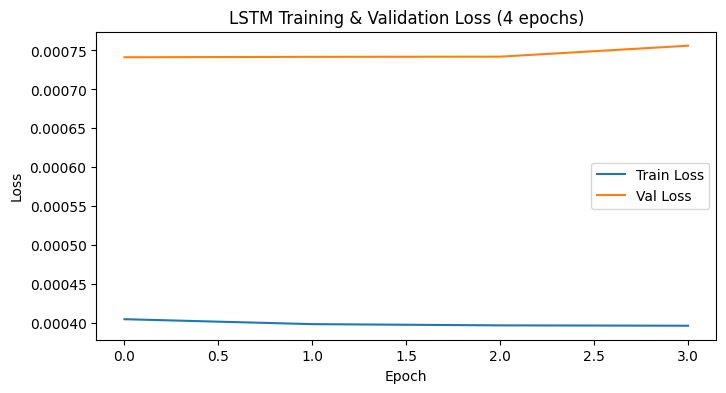

In [32]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training & Validation Loss (4 epochs)")
plt.legend()
plt.show()


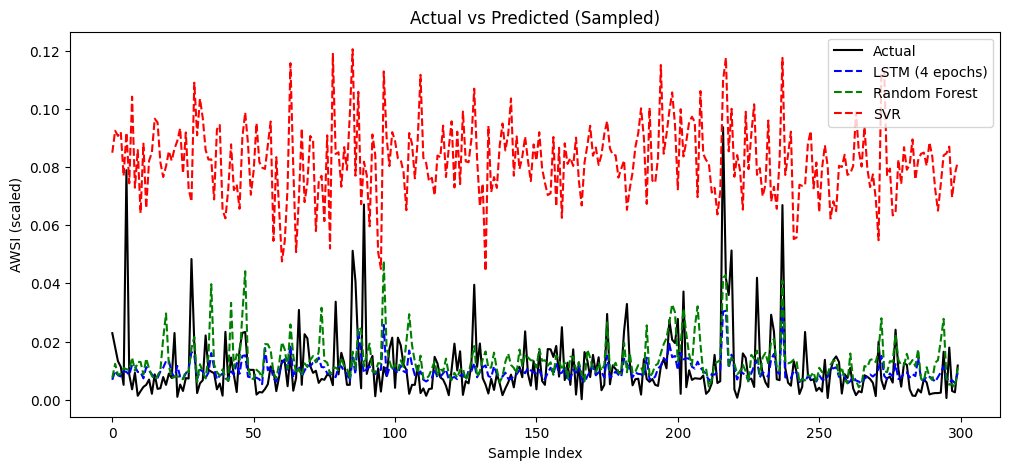

In [33]:
# Sample points to plot for speed
sample_size = 300
indices = sorted(random.sample(range(len(y_test)), min(sample_size, len(y_test))))

plt.figure(figsize=(12,5))
plt.plot(np.array(y_test)[indices], label='Actual', color='black')
plt.plot(np.array(y_pred_lstm)[indices], label='LSTM (4 epochs)', linestyle='--', color='blue')
plt.plot(np.array(y_pred_rf)[indices], label='Random Forest', linestyle='--', color='green')
plt.plot(np.array(y_pred_svr)[indices], label='SVR', linestyle='--', color='red')
plt.title("Actual vs Predicted (Sampled)")
plt.xlabel("Sample Index")
plt.ylabel("AWSI (scaled)")
plt.legend()
plt.show()


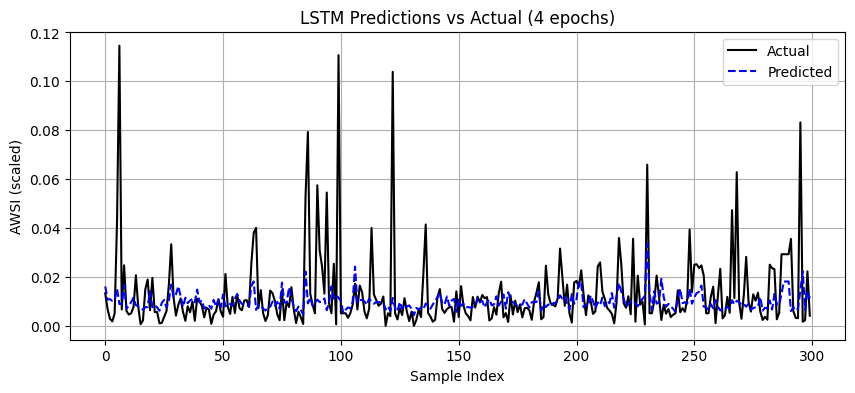

In [34]:
# Sample points for speed
sample_size = 300
indices = sorted(random.sample(range(len(y_test)), min(sample_size, len(y_test))))

plt.figure(figsize=(10,4))
plt.plot(np.array(y_test)[indices], label='Actual', color='black')
plt.plot(np.array(y_pred_lstm)[indices], label='Predicted', linestyle='--', color='blue')
plt.title("LSTM Predictions vs Actual (4 epochs)")
plt.xlabel("Sample Index")
plt.ylabel("AWSI (scaled)")
plt.legend()
plt.grid(True)
plt.show()


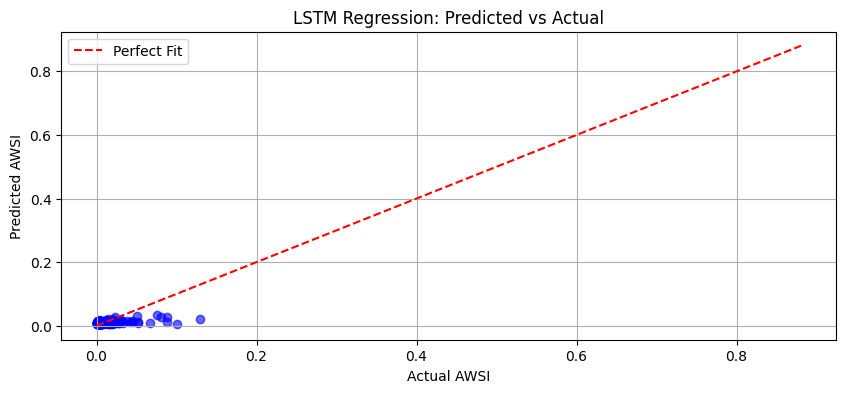

In [35]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Sample 300 points to speed up plotting
sample_size = 300
indices = sorted(random.sample(range(len(y_test)), min(sample_size, len(y_test))))

plt.figure(figsize=(10,4))
plt.scatter(np.array(y_test)[indices], np.array(y_pred_lstm)[indices], color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.title("LSTM Regression: Predicted vs Actual")
plt.xlabel("Actual AWSI")
plt.ylabel("Predicted AWSI")
plt.legend()
plt.grid(True)
plt.show()


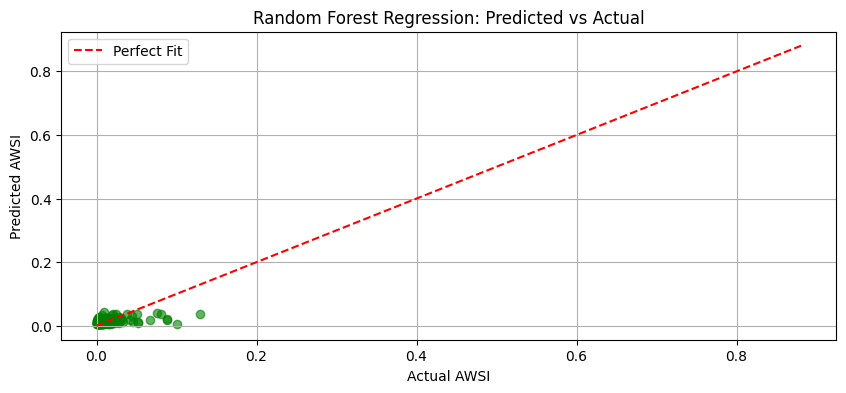

In [36]:
plt.figure(figsize=(10,4))
plt.scatter(np.array(y_test)[indices], np.array(y_pred_rf)[indices], color='green', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.title("Random Forest Regression: Predicted vs Actual")
plt.xlabel("Actual AWSI")
plt.ylabel("Predicted AWSI")
plt.legend()
plt.grid(True)
plt.show()


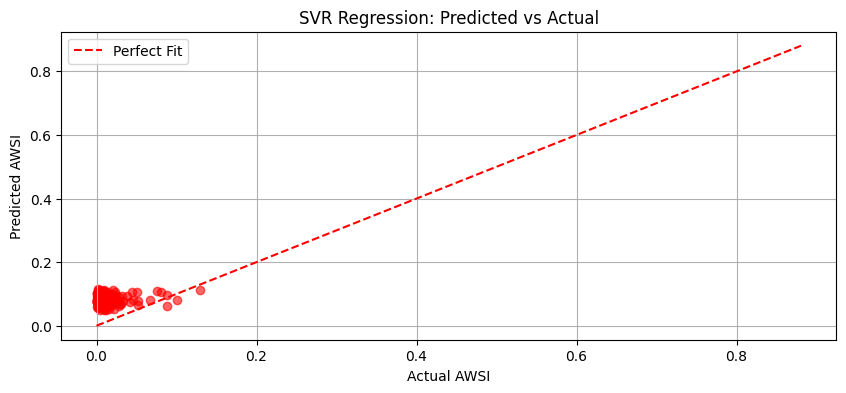

In [37]:
plt.figure(figsize=(10,4))
plt.scatter(np.array(y_test)[indices], np.array(y_pred_svr)[indices], color='red', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.title("SVR Regression: Predicted vs Actual")
plt.xlabel("Actual AWSI")
plt.ylabel("Predicted AWSI")
plt.legend()
plt.grid(True)
plt.show()


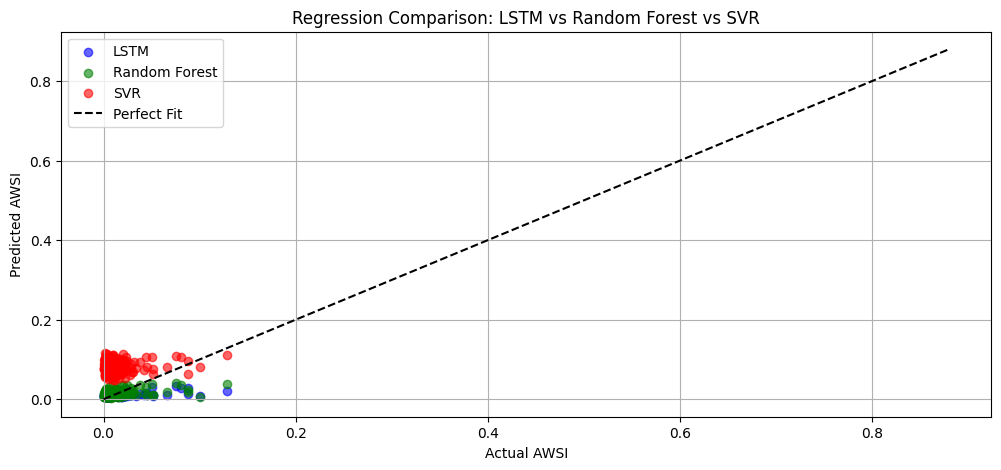

In [38]:
plt.figure(figsize=(12,5))
plt.scatter(np.array(y_test)[indices], np.array(y_pred_lstm)[indices], color='blue', alpha=0.6, label='LSTM')
plt.scatter(np.array(y_test)[indices], np.array(y_pred_rf)[indices], color='green', alpha=0.6, label='Random Forest')
plt.scatter(np.array(y_test)[indices], np.array(y_pred_svr)[indices], color='red', alpha=0.6, label='SVR')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Perfect Fit')
plt.title("Regression Comparison: LSTM vs Random Forest vs SVR")
plt.xlabel("Actual AWSI")
plt.ylabel("Predicted AWSI")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
def plot_swan(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
    plt.title(f'SWAN Plot - {model_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()


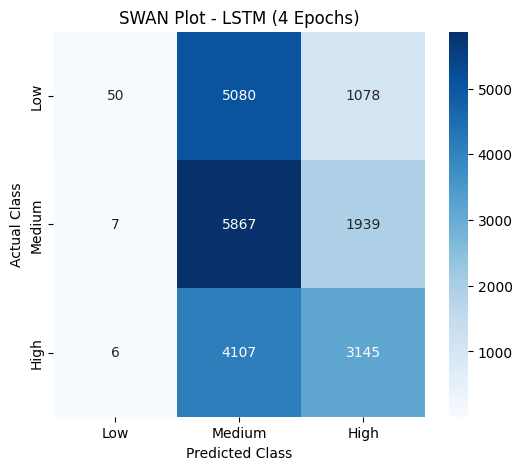

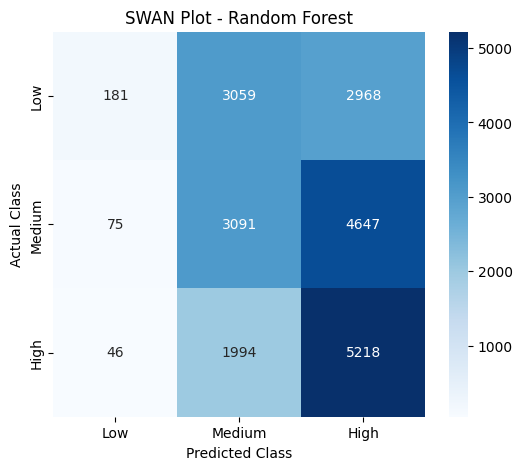

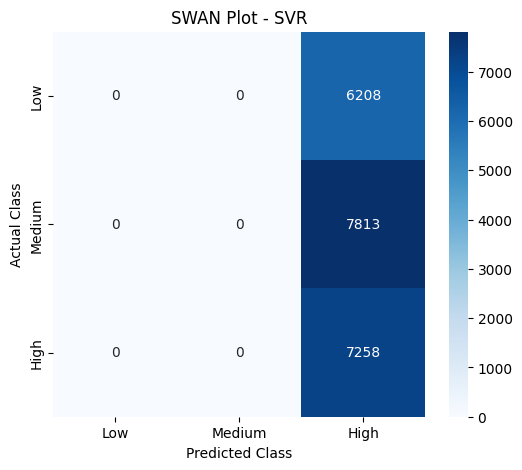

In [45]:
plot_swan(y_test_class, y_pred_lstm_class, "LSTM (4 Epochs)")
plot_swan(y_test_class, y_pred_rf_class, "Random Forest")
plot_swan(y_test_class, y_pred_svr_class, "SVR")
